In [20]:
!python -V

Python 3.9.12


In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [22]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [46]:
def read_dataframe(filename):
    #load file
    df = pd.read_parquet(filename)
    #convert column to datetime type
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    #convert column to datetime type
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    #creates column duration which is difference dropoff time - pickup time
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    #td == Timedelta. This converts it into seconds and / 60 making it minutes
    df.duration = df.duration.apply(lambda td:td.total_seconds() / 60)
    #filter dataframe and reassign to all rows that contain duration btw 1 min and 60 min
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    #assign variables for numerical and categorical data in dataset for further
    #one hotting categorical data
    categorical = ['PULocationID','DOLocationID']
    numerical = ['trip_distance']
    #categorical must be str objects in pandas
    df[categorical] = df[categorical].astype(str)
    return df

In [47]:
#assign train and validation datasets
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [48]:
#check sizes of datasets
len(df_train), len(df_val)

(73908, 61921)

In [49]:
#engineer feature to concatenate PU and DO times in 1 column
df_train['PU_DO']= df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO']= df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [63]:

categorical = ['PU_DO']
numerical = ['trip_distance']
#dv will create one hot encoding for categorical data
dv = DictVectorizer()
#to make one hot dv needs data in dictionary format
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
#dv is a model itself so it needs to learn data
X_train = dv.fit_transform(train_dicts)
#validation set can be transformed without learning
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [64]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [65]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.479562160810692

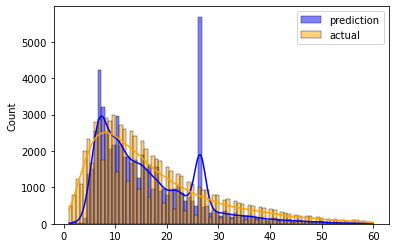

In [68]:
sns.histplot(y_pred, label='prediction', kde=True, color='blue')
sns.histplot(y_train, label='actual', kde=True, color='orange')
plt.legend()  # Show labels
plt.show()

In [69]:
#save model and datavectorizer to preserve training data
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)